We are grateful for this suggestion. The exact product specified does not appear to be available on Copernicus Marine Service, but we suspect that this is an alternative name for the product NWSHELF_MULTIYEAR_BGC_004_011 (https://resources.marine.copernicus.eu/?option=com_csw&view=details&product_id=NWSHELF_MULTIYEAR_BGC_004_011), a 7km horizontal resolution NEMO-NEMOVAR reanalysis using the European Regional Seas Ecosystem Model (ERSEM).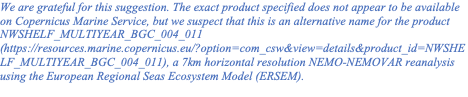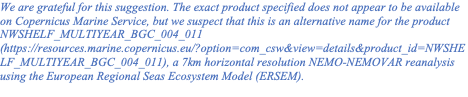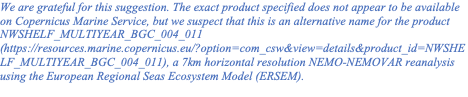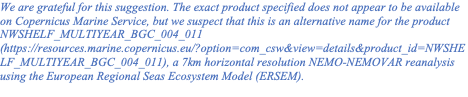

This product assimilates: satellite Chlorophyll PFTs from ESA-CCI. • OCEANCOLOUR_GLO_CHL_L3_REP_OBSERVATIONS_009_065
So not sure what it adds beyond satellite in terms of the surface. I guess could compare at depth (would need to do output chl. From depth, maybe profile?)?
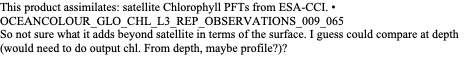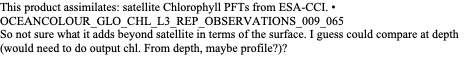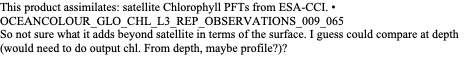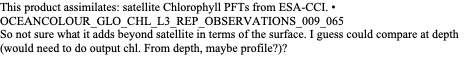

In [1]:
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition


In [44]:
def extract_region(cube,lon_west,lon_east,lat_south,lat_north):
    cube_region_tmp = cube.intersection(longitude=(lon_west, lon_east))
    cube_region = cube_region_tmp.intersection(latitude=(lat_south, lat_north))
    return cube_region


def area_avg(cube):
    try:
        cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    return cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)


def common_years(cube1,cube2):
    cube1_yrs = cube1.coord('year').points
    cube2_yrs = cube2.coord('year').points
    years= np.intersect1d(cube1_yrs,cube2_yrs)
    cube1_ind= np.in1d(cube1_yrs,cube2_yrs)
    cube2_ind= np.in1d(cube2_yrs,cube1_yrs)
    return years,cube1.data[cube1_ind],cube2.data[cube2_ind]


def compariable_across_grids(cube1,cube2,lon_west,lon_east,lat_south,lat_north):
    cube1_region = extract_region(cube1,lon_west,lon_east,lat_south,lat_north)
    cube2_region = extract_region(cube2,lon_west,lon_east,lat_south,lat_north)
    
    cube2_region.coord('latitude').coord_system = cube1_region.coord('latitude').coord_system
    cube2_region.coord('longitude').coord_system =cube1_region.coord('longitude').coord_system

    cube1_region_regridded = cube1_region.regrid(cube2_region, iris.analysis.Linear())
    cube2_region.data.mask = cube1_region_regridded.data.mask


    cube2_region.data[np.where(cube2_region.data < -20.0)] = cube2_region.data.fill_value
    cube2_region.data[np.where(cube2_region.data >100.0)] = cube2_region.data.fill_value
    cube2_region.data = np.ma.masked_where(cube2_region.data == cube2_region.data.fill_value, cube2_region.data)

    cube1_region_regridded.data[np.where(cube1_region_regridded.data < -20.0)] = cube1_region_regridded.data.fill_value
    cube1_region_regridded.data[np.where(cube1_region_regridded.data > 100.0)] = cube1_region_regridded.data.fill_value
    cube1_region_regridded.data = np.ma.masked_where(cube1_region_regridded.data == cube1_region_regridded.data.fill_value, cube1_region_regridded.data)
    return cube1_region_regridded,cube2_region


def select_range(cube, my_range):
    return cube[np.where((cube.coord('year').points >= my_range[0]) & (cube.coord('year').points <= my_range[1]))]


def add_year(cube):
    import iris.coord_categorisation
    try:
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    except:
        pass
    return cube

def monthly_to_yearly(cube):
    cube = add_year(cube)
    cube = cube.aggregated_by('year',iris.analysis.MEAN)
    return cube

In [73]:
#NEMO-NEMOVAR ERSEM
nemo_cube = iris.load_cube('/Users/ph290/Downloads/NWSHELF_MULTIYEAR_BGC_004_011_CHL_monthly/metoffice_foam1_amm7_NWS_CPWC_mm_1993_2019.nc')
nemo_cube = add_year(nemo_cube)

# S2P3
s2p3_cube = iris.load_cube('/Users/ph290/Downloads/UK/era5_uk_surfacechlorophyll_mm.nc')
s2p3_cube = add_year(s2p3_cube)

# CCI satellite
obs_cube = iris.load_cube('/Users/ph290/Downloads/obs_data/CCI_ALL-v4.2-MONTHLY_region.nc')
obs_cube = add_year(obs_cube)

#bathymetry data
bathy_file = '/Users/ph290/Downloads/ETOPO1_Bed_g_gmt4_low_res.nc'
bathy_cube = iris.load_cube(bathy_file)
bathy_cube.data = np.ma.masked_where(bathy_cube.data >= 0.0,bathy_cube.data)
bathy_cube.data = np.ma.masked_where(bathy_cube.data < -100.0,bathy_cube.data)


/Users/ph290/opt/miniconda3/envs/mypython3/lib/python3.9/site-packages/iris/fileformats/cf.py:285: UserWarning: Missing CF-netCDF ancillary data variable 'chlor_a_log10_rmsd', referenced by netCDF variable 'chlor_a'
  warnings.warn(message % (name, nc_var_name))
/Users/ph290/opt/miniconda3/envs/mypython3/lib/python3.9/site-packages/iris/fileformats/cf.py:285: UserWarning: Missing CF-netCDF ancillary data variable 'chlor_a_log10_bias', referenced by netCDF variable 'chlor_a'
  warnings.warn(message % (name, nc_var_name))


In [74]:
comparable_years = [1997,2019]


#annual avg:
nemo_cube = monthly_to_yearly(nemo_cube)
s2p3_cube = monthly_to_yearly(s2p3_cube)
obs_cube = monthly_to_yearly(obs_cube)
    
nemo_cube = select_range(nemo_cube, comparable_years)
s2p3_cube = select_range(s2p3_cube, comparable_years)
obs_cube = select_range(obs_cube, comparable_years)

In [75]:
lon_west,lon_east,lat_south,lat_north = -6.5,5.0,48.5,59.0

bathy_cube_region = extract_region(bathy_cube,lon_west,lon_east,lat_south,lat_north)
nemo_cube_region = extract_region(nemo_cube,lon_west,lon_east,lat_south,lat_north)
s2p3_cube_region = extract_region(s2p3_cube,lon_west,lon_east,lat_south,lat_north)
obs_cube_region = extract_region(obs_cube,lon_west,lon_east,lat_south,lat_north)



In [123]:

nemo_cube_regridded = nemo_cube[:,0,:,:].regrid(s2p3_cube_region, iris.analysis.Linear())
obs_cube_regridded = obs_cube.regrid(s2p3_cube_region, iris.analysis.Linear())
s2p3_cube_regridded = s2p3_cube_region
bathy_cube_regridded = bathy_cube_region.regrid(s2p3_cube_region[0,:,:], iris.analysis.Linear())
bathy_cube_regridded_3d = np.tile(bathy_cube_regridded.data,(np.shape(obs_cube_regridded)[0],1,1))

# bathy_data = bathy_cube.data
# lat_bathy = bathy_cube.coord('latitude').points
# lon_bathy = bathy_cube.coord('longitude').points

# bathy_cube_regridded = bathy_cube.regrid(c_model, iris.analysis.Linear())



/Users/ph290/opt/miniconda3/envs/mypython3/lib/python3.9/site-packages/iris/coords.py:1803: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/Users/ph290/opt/miniconda3/envs/mypython3/lib/python3.9/site-packages/iris/coords.py:1803: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


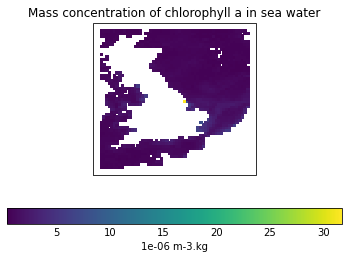

In [124]:
# MASK DATA SHALLOWER THAN 70m

In [125]:
def mask_range(bathy_cube, other_cube,min_depth,max_depth):
    #NOte all cubes must be on the same grid
    other_cube_masked = other_cube.copy()
    other_cube_data = other_cube.data
    other_cube_data = np.ma.masked_where(bathy_cube.data >= (-1.0 * min_depth),other_cube_data)
    other_cube_data = np.ma.masked_where(bathy_cube.data < (-1.0 * max_depth),other_cube_data)
    other_cube_masked.data = other_cube_data
    return other_cube_masked



nemo_cube_regridded_masked = mask_range(bathy_cube_regridded_3d, nemo_cube_regridded,70.0,100.0)
s2p3_cube_regridded_masked = mask_range(bathy_cube_regridded_3d, s2p3_cube_regridded,70.0,100.0)
obs_cube_regridded_masked = mask_range(bathy_cube_regridded_3d, obs_cube_regridded,70.0,100.0)




In [127]:
print(nemo_cube_regridded_masked.coord('year').points)
print(s2p3_cube_regridded_masked.coord('year').points)
print(obs_cube_regridded_masked.coord('year').points)

[1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017 2018 2019]
[1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017 2018 2019]
[1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017 2018 2019]


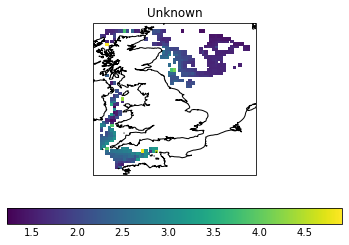

In [167]:
qplt.pcolormesh(s2p3_cube_regridded_masked[0])
plt.gca().coastlines()

/Users/ph290/opt/miniconda3/envs/mypython3/lib/python3.9/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


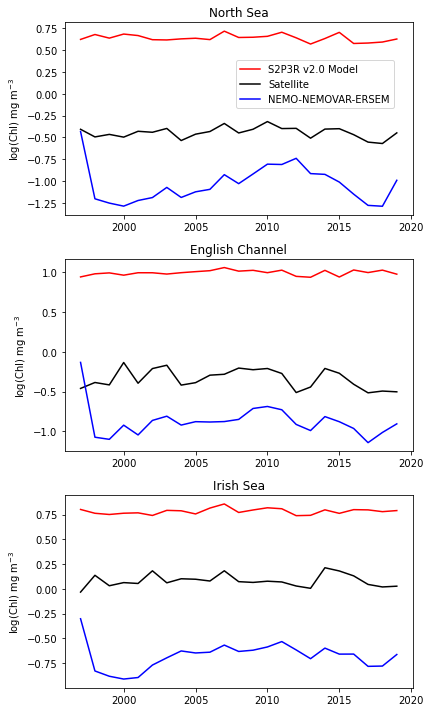

In [165]:
# model_region_regridded = s2p3_cube
# nemo_region = nemo_cube[:,0,:,:]
# obs_region = obs_cube

projection=ccrs.PlateCarree()

lon_west = -2.5
lon_east = 5.0
lat_south = 51
lat_north = 59
cube_all_region_area_avg_1 = area_avg(extract_region(s2p3_cube_regridded_masked,lon_west,lon_east,lat_south,lat_north))
nemo_cube_all_region_area_avg_1 = area_avg(extract_region(nemo_cube_regridded_masked,lon_west,lon_east,lat_south,lat_north))
obs_cube_all_region_area_avg_1 = area_avg(extract_region(obs_cube_regridded_masked,lon_west,lon_east,lat_south,lat_north))
lon_west = -5.5
lon_east = 1.5
lat_south = 48.5
lat_north = 51.0
cube_all_region_area_avg_2 = area_avg(extract_region(s2p3_cube_regridded_masked,lon_west,lon_east,lat_south,lat_north))
nemo_cube_all_region_area_avg_2 = area_avg(extract_region(nemo_cube_regridded_masked,lon_west,lon_east,lat_south,lat_north))
obs_cube_all_region_area_avg_2 = area_avg(extract_region(obs_cube_regridded_masked,lon_west,lon_east,lat_south,lat_north))
lon_west = -6.5
lon_east = -2.5
lat_south = 51.0
lat_north = 55.5
cube_all_region_area_avg_3 = area_avg(extract_region(s2p3_cube_regridded_masked,lon_west,lon_east,lat_south,lat_north))
obs_cube_all_region_area_avg_3 = area_avg(extract_region(obs_cube_regridded_masked,lon_west,lon_east,lat_south,lat_north))
nemo_cube_all_region_area_avg_3 = area_avg(extract_region(nemo_cube_regridded_masked,lon_west,lon_east,lat_south,lat_north))


fig,axes= plt.subplots(nrows=3, ncols=1,figsize=(6, 10))

yr,y1,y2 = common_years(cube_all_region_area_avg_1,obs_cube_all_region_area_avg_1)
yr1,y1,y3 = common_years(cube_all_region_area_avg_1,nemo_cube_all_region_area_avg_1)

axes[0].plot(yr,np.log(y1),'r',label='S2P3R v2.0 Model')
# ax00b = axes[0].twinx() 
# ax00b.plot(yr,y3,'k',label='NEMO-NEMOVAR-ERSEM Chl')
axes[0].plot(yr,np.log(y2),'k',label='Satellite')
axes[0].plot(yr,np.log(y3),'b',label='NEMO-NEMOVAR-ERSEM')
axes[0].set_title('North Sea')
axes[0].set_ylabel('log(Chl) mg m$^{-3}$', color='k') 
# ax00b.set_ylabel('Chl', color='k') 



yr,y1,y2 = common_years(cube_all_region_area_avg_2,obs_cube_all_region_area_avg_2)
yr1,y1,y3 = common_years(cube_all_region_area_avg_2,nemo_cube_all_region_area_avg_2)

axes[1].plot(yr,np.log(y1),'r',label='S2P3R v2.0 Model Chl')
axes[1].plot(yr,np.log(y2),'k',label='Satellite Chl')
axes[1].plot(yr,np.log(y3),'b',label='NEMO-NEMOVAR-ERSEM Chl')
axes[1].set_title('English Channel')
axes[1].set_ylabel('log(Chl) mg m$^{-3}$', color='k') 

yr,y1,y2 = common_years(cube_all_region_area_avg_3,obs_cube_all_region_area_avg_3)
yr1,y1,y3 = common_years(cube_all_region_area_avg_3,nemo_cube_all_region_area_avg_3)

axes[2].plot(yr,np.log(y1),'r',label='S2P3R v2.0 Model Chl')
axes[2].plot(yr,np.log(y2),'k',label='Satellite Chl')
axes[2].plot(yr,np.log(y3),'b',label='NEMO-NEMOVAR-ERSEM Chl')
axes[2].set_title('Irish Sea')
axes[2].set_ylabel('log(Chl) mg m$^{-3}$', color='k') 

axes[0].legend(bbox_to_anchor=(0.04, 0.73, 0.92, .1))
plt.tight_layout()


plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/Revisions and response/figures/uk_chl_validation_v_nemoErsem.pdf')
plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/Revisions and response/figures/uk_chl_validation_v_nemoErsem.png')



In [25]:
yr,y1,y2 = common_years(cube_all_region_area_avg_1,obs_cube_all_region_area_avg_1)
yr1,y1,y3 = common_years(cube_all_region_area_avg_1,nemo_cube_all_region_area_avg_1)


print(cube_all_region_area_avg_1.coord('year'))
print(obs_cube_all_region_area_avg_1.coord('year'))
print(nemo_cube_all_region_area_avg_1.coord('year'))

AuxCoord(array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]), standard_name=None, units=Unit('1'), long_name='year')
AuxCoord(array([1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]), standard_name=None, units=Unit('1'), long_name='year')
AuxCoord(array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]), standard_name=None, units=Unit('1'), long_name='year')


Something odd happening early on. Maybe look just post 2000 ifn case nemo has a spin up issue of an assimilation switch?

In [6]:
comparable_years = [2008,2017]

#annual avg:
nemo_cube = monthly_to_yearly(nemo_cube)
s2p3_cube = monthly_to_yearly(s2p3_cube)
obs_cube = monthly_to_yearly(obs_cube)
    
nemo_cube2 = select_range(nemo_cube, comparable_years)
s2p3_cube2 = select_range(s2p3_cube, comparable_years)
obs_cube2 = select_range(obs_cube, comparable_years)

/Users/ph290/opt/miniconda3/envs/mypython3/lib/python3.9/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/Users/ph290/opt/miniconda3/envs/mypython3/lib/python3.9/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/Users/ph290/opt/miniconda3/envs/mypython3/lib/python3.9/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/Users/ph290/opt/miniconda3/envs/mypython3/lib/python3.9/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/Users/ph290/opt/miniconda3/envs/mypython3/lib/python3.9/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_

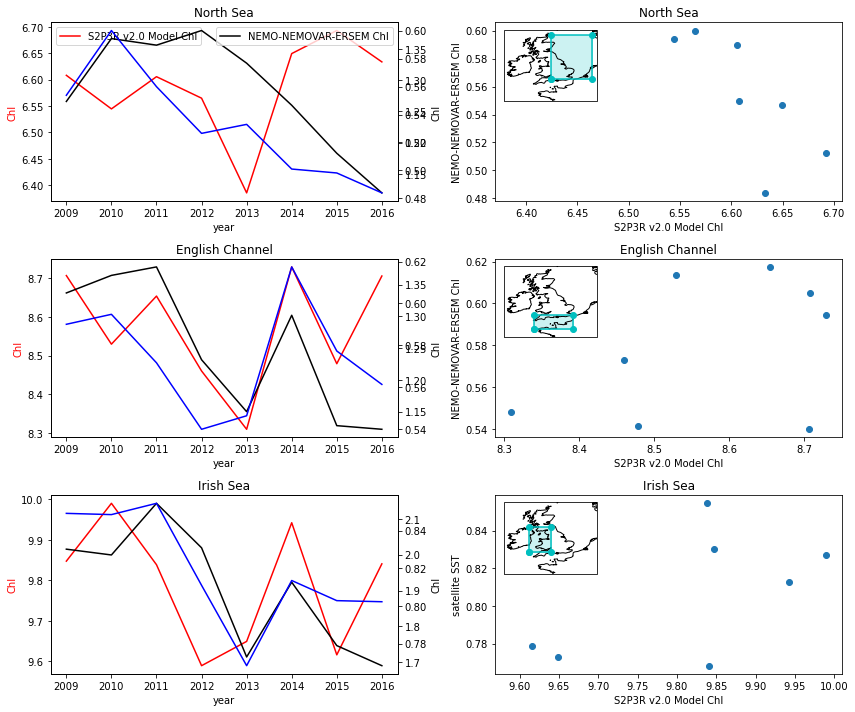

In [7]:
model_region_regridded = s2p3_cube2
obs_region = nemo_cube2[:,0,:,:]
obs_regionb = obs_cube2

projection=ccrs.PlateCarree()

lon_west = -2.5
lon_east = 5.0
lat_south = 51
lat_north = 59
cube_all_region_area_avg_1 = area_avg(extract_region(model_region_regridded,lon_west,lon_east,lat_south,lat_north))
obs_cube_all_region_area_avg_1 = area_avg(extract_region(obs_region,lon_west,lon_east,lat_south,lat_north))
obs_cube_all_region_area_avg_1b = area_avg(extract_region(obs_regionb,lon_west,lon_east,lat_south,lat_north))
lon_west = -5.5
lon_east = 1.5
lat_south = 48.5
lat_north = 51.0
cube_all_region_area_avg_2 = area_avg(extract_region(model_region_regridded,lon_west,lon_east,lat_south,lat_north))
obs_cube_all_region_area_avg_2 = area_avg(extract_region(obs_region,lon_west,lon_east,lat_south,lat_north))
obs_cube_all_region_area_avg_2b = area_avg(extract_region(obs_regionb,lon_west,lon_east,lat_south,lat_north))
lon_west = -6.5
lon_east = -2.5
lat_south = 51.0
lat_north = 55.5
cube_all_region_area_avg_3 = area_avg(extract_region(model_region_regridded,lon_west,lon_east,lat_south,lat_north))
obs_cube_all_region_area_avg_3 = area_avg(extract_region(obs_region,lon_west,lon_east,lat_south,lat_north))
obs_cube_all_region_area_avg_3b = area_avg(extract_region(obs_regionb,lon_west,lon_east,lat_south,lat_north))




fig,axes= plt.subplots(nrows=3, ncols=2,figsize=(12, 10))

yr,y1,y2 = common_years(cube_all_region_area_avg_1,obs_cube_all_region_area_avg_1)
yr,y1,y3 = common_years(cube_all_region_area_avg_1,obs_cube_all_region_area_avg_1b)

axes[0,0].plot(yr,y1,'r',label='S2P3R v2.0 Model Chl')
ax00b = axes[0,0].twinx() 
ax00b.plot(yr,y2,'k',label='NEMO-NEMOVAR-ERSEM Chl')
ax00c = axes[0,0].twinx() 
ax00c.plot(yr,y3,'b',label='CCI Chl')
axes[0,0].set_title('North Sea')
axes[0,0].set_ylabel('Chl', color='r') 
ax00b.set_ylabel('Chl', color='k') 


axes[0,1].scatter(y1,y2,label='S2P3R v2.0 Model Chl v. satellite Chl')
axes[0,1].set_xlabel('S2P3R v2.0 Model Chl')
axes[0,1].set_ylabel('NEMO-NEMOVAR-ERSEM Chl')
# axes[0,1].plot([0,100],[0,100])
# axes[0,1].set_xlim([8.5,11.7])
# axes[0,1].set_ylim([8.5,11.7])
axes[0,1].set_title('North Sea')

yr,y1,y2 = common_years(cube_all_region_area_avg_2,obs_cube_all_region_area_avg_2)
yr,y1,y3 = common_years(cube_all_region_area_avg_2,obs_cube_all_region_area_avg_2b)

axes[1,0].plot(yr,y1,'r',label='S2P3R v2.0 Model SST')
ax10b = axes[1,0].twinx() 
ax10b.plot(yr,y2,'k',label='NEMO-NEMOVAR-ERSEM satellite Chl')
ax10c = axes[1,0].twinx() 
ax10c.plot(yr,y3,'b',label='CCI Chl')
axes[1,0].set_title('English Channel')
axes[1,0].set_ylabel('Chl', color='r') 
ax10b.set_ylabel('Chl', color='k') 

axes[1,1].scatter(y1,y2,label='S2P3R v2.0 Model Chl v. satellite Chl')
axes[1,1].set_xlabel('S2P3R v2.0 Model Chl')
axes[1,1].set_ylabel('NEMO-NEMOVAR-ERSEM Chl')
# axes[1,1].plot([0,100],[0,100])
# axes[1,1].set_xlim([11.0,14.0])
# axes[1,1].set_ylim([11.0,14.0])
axes[1,1].set_title('English Channel')

yr,y1,y2 = common_years(cube_all_region_area_avg_3,obs_cube_all_region_area_avg_3)
yr,y1,y3 = common_years(cube_all_region_area_avg_3,obs_cube_all_region_area_avg_3b)


axes[2,0].plot(yr,y1,'r',label='S2P3R v2.0 Model Chl')
ax20b = axes[2,0].twinx() 
ax20b.plot(yr,y2,'k',label='NEMO-NEMOVAR-ERSEM satellite Chl')
ax20c = axes[2,0].twinx() 
ax20c.plot(yr,y3,'b',label='CCI Chl')
axes[2,0].set_title('Irish Sea')
axes[2,0].set_ylabel('Chl', color='r') 
ax20b.set_ylabel('Chl', color='k') 

axes[2,1].scatter(y1,y2,label='S2P3R v2.0 Model Chl v. NEMO-NEMOVAR-ERSEM Chl')
axes[2,1].set_xlabel('S2P3R v2.0 Model Chl')
axes[2,1].set_ylabel('satellite SST')
# axes[2,1].plot([0,100],[0,100])
# axes[2,1].set_xlim([9.5,12.5])
# axes[2,1].set_ylim([9.5,12.5])
axes[2,1].set_title('Irish Sea')



axes[0,0].legend(fancybox=True)
ax00b.legend(loc=1,fancybox=True)

axes[0,0].set_xlabel('year', color='k') 
axes[1,0].set_xlabel('year', color='k') 
axes[2,0].set_xlabel('year', color='k') 


inset_x = 0
inset_y = 1
inset_size = 0.4

inset_ax1 = plt.axes([0, 0, 1, 1], projection=projection)
inset_ax1.set_extent([-11, 6, 47, 60], ccrs.PlateCarree())
inset_ax1.coastlines('50m')
ip1 = InsetPosition(axes[0,1], [inset_x - inset_size*0.1,
                        inset_y - inset_size*1.1,
                        inset_size,
                        inset_size])
inset_ax1.set_axes_locator(ip1)
lon_west = -2.5
lon_east = 5.0
lat_south = 51
lat_north = 59
x, y = [lon_west, lon_west, lon_east, lon_east, lon_west], [lat_south, lat_north, lat_north, lat_south,lat_south]
inset_ax1.plot(x, y, 'c',marker='o', transform=projection)
inset_ax1.fill(x, y, color='c', transform=projection, alpha=0.2)


inset_ax2 = plt.axes([0, 0, 2, 2], projection=projection)
inset_ax2.set_extent([-11, 6, 47, 60], ccrs.PlateCarree())
inset_ax2.coastlines('50m')
ip2 = InsetPosition(axes[1,1], [inset_x - inset_size*0.1,
                        inset_y - inset_size*1.1,
                        inset_size,
                        inset_size])
inset_ax2.set_axes_locator(ip2)
lon_west = -5.5
lon_east = 1.5
lat_south = 48.5
lat_north = 51.0
x, y = [lon_west, lon_west, lon_east, lon_east, lon_west], [lat_south, lat_north, lat_north, lat_south,lat_south]
inset_ax2.plot(x, y, 'c',marker='o', transform=projection)
inset_ax2.fill(x, y, color='c', transform=projection, alpha=0.2)


inset_ax3 = plt.axes([0, 0, 3, 3], projection=projection)
inset_ax3.set_extent([-11, 6, 47, 60], ccrs.PlateCarree())
inset_ax3.coastlines('50m')
ip3 = InsetPosition(axes[2,1], [inset_x - inset_size*0.1,
                        inset_y - inset_size*1.1,
                        inset_size,
                        inset_size])
inset_ax3.set_axes_locator(ip3)
lon_west = -6.5
lon_east = -2.5
lat_south = 51.0
lat_north = 55.5
x3, y3 = [lon_west, lon_west, lon_east, lon_east, lon_west], [lat_south, lat_north, lat_north, lat_south,lat_south]
inset_ax3.plot(x3, y3, 'c',marker='o', transform=projection)
inset_ax3.fill(x3, y3, color='c', transform=projection, alpha=0.2)

plt.tight_layout()


plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/uk_chl_validation_v_nemoErsem2.pdf')
plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/uk_chl_validation_v_nemoErsem2.png')



In [9]:
model_region_regridded = s2p3_cube2
obs_region = nemo_cube2[:,0,:,:]
obs_regionb = obs_cube2

# projection=ccrs.PlateCarree()

# lon_west = -2.5
# lon_east = 5.0
# lat_south = 51
# lat_north = 59
# cube_all_region_area_avg_1 = area_avg(extract_region(model_region_regridded,lon_west,lon_east,lat_south,lat_north))
# obs_cube_all_region_area_avg_1 = area_avg(extract_region(obs_region,lon_west,lon_east,lat_south,lat_north))
# obs_cube_all_region_area_avg_1b = area_avg(extract_region(obs_regionb,lon_west,lon_east,lat_south,lat_north))
# lon_west = -5.5
# lon_east = 1.5
# lat_south = 48.5
# lat_north = 51.0
# cube_all_region_area_avg_2 = area_avg(extract_region(model_region_regridded,lon_west,lon_east,lat_south,lat_north))
# obs_cube_all_region_area_avg_2 = area_avg(extract_region(obs_region,lon_west,lon_east,lat_south,lat_north))
# obs_cube_all_region_area_avg_2b = area_avg(extract_region(obs_regionb,lon_west,lon_east,lat_south,lat_north))
# lon_west = -6.5
# lon_east = -2.5
# lat_south = 51.0
# lat_north = 55.5
# cube_all_region_area_avg_3 = area_avg(extract_region(model_region_regridded,lon_west,lon_east,lat_south,lat_north))
# obs_cube_all_region_area_avg_3 = area_avg(extract_region(obs_region,lon_west,lon_east,lat_south,lat_north))
# obs_cube_all_region_area_avg_3b = area_avg(extract_region(obs_regionb,lon_west,lon_east,lat_south,lat_north))




# fig,axes= plt.subplots(nrows=3, ncols=2,figsize=(12, 10))

yr,y1,y2 = common_years(cube_all_region_area_avg_1,obs_cube_all_region_area_avg_1)
yr,y1,y3 = common_years(y1,obs_cube_all_region_area_avg_1b)

AttributeError: 'MaskedArray' object has no attribute 'coord'

In [10]:
obs_cube_all_region_area_avg_1b

Mass Concentration Of Chlorophyll A In Sea Water (milligram m-3),time
Shape,8
Dimension coordinates,
time,x
Auxiliary coordinates,
year,x
Scalar coordinates,
latitude,"55.0 degrees, bound=(50.99999809265137, 59.00000190734863) degrees"
longitude,"1.2499998211860657 degrees, bound=(-2.5000001192092896, 4.999999761581421) degrees"
Attributes,
CDI,Climate Data Interface version 1.9.5 (http://mpimet.mpg.de/cdi)


In [11]:
nemo_cube_tm = nemo_cube[-15::].collapsed('time',iris.analysis.MEAN)

nemo_cube_tm2 = nemo_cube[0:3].collapsed('time',iris.analysis.MEAN)


/Users/ph290/opt/miniconda3/envs/mypython3/lib/python3.9/site-packages/iris/coords.py:1979: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/Users/ph290/opt/miniconda3/envs/mypython3/lib/python3.9/site-packages/iris/coords.py:1979: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))
/Users/ph290/opt/miniconda3/envs/mypython3/lib/python3.9/site-packages/iris/coords.py:1979: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/Users/ph290/opt/miniconda3/envs/mypython3/lib/python3.9/site-packages/iris/coords.py:1979: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))


/Users/ph290/opt/miniconda3/envs/mypython3/lib/python3.9/site-packages/iris/coords.py:1803: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/Users/ph290/opt/miniconda3/envs/mypython3/lib/python3.9/site-packages/iris/coords.py:1803: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


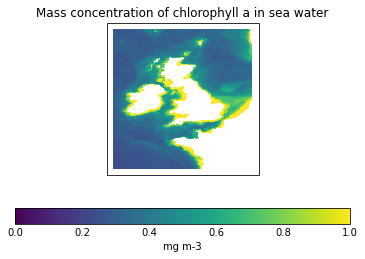

In [12]:
lon_west = -12.0
lon_east = 5.0
lat_south = 45.0
lat_north = 62.0

nemo_cube_tm_region = extract_region(nemo_cube_tm,lon_west,lon_east,lat_south,lat_north)
nemo_cube_tm_region2 = extract_region(nemo_cube_tm2,lon_west,lon_east,lat_south,lat_north)

qplt.pcolormesh(nemo_cube_tm_region[0],vmin=0,vmax=1)




In [13]:
nemo_cube

<iris 'Cube' of mass_concentration_of_chlorophyll_a_in_sea_water / (mg m-3) (time: 25; depth: 24; latitude: 375; longitude: 297)>

In [14]:
s2p3_cube_tm = s2p3_cube[-15::].collapsed('time',iris.analysis.MEAN)
qplt.pcolormesh(s2p3_cube_tm[-2],vmin=0,vmax=5)

/Users/ph290/opt/miniconda3/envs/mypython3/lib/python3.9/site-packages/iris/coords.py:1979: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/Users/ph290/opt/miniconda3/envs/mypython3/lib/python3.9/site-packages/iris/coords.py:1979: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))


ValueError: Cube must be 2-dimensional. Got 1 dimensions.

In [ ]:
lon_west = -12.0
lon_east = 5.0
lat_south = 45.0
lat_north = 62.0

s2p3_cube_tm_region = extract_region(s2p3_cube_tm,lon_west,lon_east,lat_south,lat_north)

qplt.pcolormesh(s2p3_cube_tm_region,vmin=0,vmax=5)

In [ ]:
#https://icdc.cen.uni-hamburg.de/en/projekte/biogeochemical-north-sea-climatology.html
#https://icdc.cen.uni-hamburg.de/en/nsbc.html

cube_in_situ_chl= iris.load('/Users/ph290/Downloads/NWSHELF_MULTIYEAR_BGC_004_011_CHL_monthly/NSBC_Level2_chlorophyll_a__UHAM_ICDC__v1.1__0.25x0.25deg__1960_2014.nc')

In [ ]:
cube_in_situ_chl2 = cube_in_situ_chl[0]
cube_in_situ_chl2 =  monthly_to_yearly(cube_in_situ_chl2)[0]

lon_west = -12.0
lon_east = 5.0
lat_south = 45.0
lat_north = 62.0

cube_in_situ_chl2_region = extract_region(cube_in_situ_chl2[0],lon_west,lon_east,lat_south,lat_north)

qplt.pcolormesh(cube_in_situ_chl2_region,vmin=0,vmax=5)
plt.gca().coastlines()

In [ ]:
cube_in_situ_chl2

In [ ]:
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

lon_west = -12.0
lon_east = 5.0
lat_south = 45.0
lat_north = 62.0

plt.close('all')
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())


#####################

ax1.set_extent((lon_west, lon_east, lat_south, lat_north), crs=ccrs.PlateCarree())

# ax1.contour(lon_bathy, lat_bathy,bathy_data,5,colors = 'k')

cube = nemo_cube_tm_region[0]
lon_nemo, lat_nemo,nemo_data = cube.coord('longitude').points, cube.coord('latitude').points, cube.data

p1 = ax1.pcolormesh(lon_nemo, lat_nemo,np.log(nemo_data),
                transform=ccrs.PlateCarree(),
                vmin=0.0,vmax=5.0,
                cmap='viridis')
# plt.colorbar(p1)
cbar1 = fig.colorbar(p1,orientation='horizontal', ax=ax1)
# cbar1 = plt.colorbar(p1,orientation='horizontal')
# cbar1.set_label('log(mg $^{m-3}$)')
cbar1.set_label('log(mg m$^{-3}$)')

ax1.add_feature(land_10m, edgecolor='k')

ax1.title.set_text('A. NEMO-NEMOVAR ERSEM surface Chl-a\n2004-2019 mean')

#####

ax2.set_extent((lon_west, lon_east, lat_south, lat_north), crs=ccrs.PlateCarree())
#https://icdc.cen.uni-hamburg.de/en/nsbc.html

cube = cube_in_situ_chl2_region
lon_obs, lat_obs,obs_data = cube.coord('longitude').points, cube.coord('latitude').points, cube.data

p2 = ax2.pcolormesh(lon_obs, lat_obs,np.log(obs_data),
                transform=ccrs.PlateCarree(),
                vmin=0.0,vmax=5.0,
                cmap='viridis')
cbar2 = fig.colorbar(p2,orientation='horizontal', ax=ax2)

cbar2.set_label('log(mg m$^{-3}$)')

ax2.add_feature(land_10m, edgecolor='k')

ax2.title.set_text('B. North Sea Biogeochemical Climatology Chl-a')

#####


ax3.set_extent((lon_west, lon_east, lat_south, lat_north), crs=ccrs.PlateCarree())
#https://icdc.cen.uni-hamburg.de/en/nsbc.html

cube = s2p3_cube_tm_region
lon_s2p3, lat_s2p3,s2p3_data = cube.coord('longitude').points, cube.coord('latitude').points, cube.data

p3 = ax3.pcolormesh(lon_s2p3, lat_s2p3,np.log(s2p3_data),
                transform=ccrs.PlateCarree(),
                vmin=0.0,vmax=5.0,
                cmap='viridis')
cbar3 = fig.colorbar(p3,orientation='horizontal', ax=ax3)

cbar3.set_label('log(mg m$^{-3}$)')

ax3.add_feature(land_10m, edgecolor='k')

ax3.title.set_text('C. S2P3R v2.0 Model surface Chl-a\n2004-2019 mean')


In [ ]:
np.shape(obs_data)


In [ ]:
plt.close('all')
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())


ax1.set_extent((lon_west, lon_east, lat_south, lat_north), crs=ccrs.PlateCarree())

# ax1.contour(lon_bathy, lat_bathy,bathy_data,5,colors = 'k')

cube = nemo_cube_tm_region[0]
lon_nemo, lat_nemo,nemo_data = cube.coord('longitude').points, cube.coord('latitude').points, cube.data

p1 = ax1.pcolormesh(lon_nemo, lat_nemo,np.log(nemo_data),
                transform=ccrs.PlateCarree(),
                vmin=0.0,vmax=0.5,
                cmap='viridis')

In [ ]:
nemo_cube2 = iris.load_cube('/Users/ph290/Downloads/NWSHELF_MULTIYEAR_BGC_004_011_CHL_monthly/metoffice_foam1_amm7_NWS_CPWC_mm_1993_2019.nc')


In [ ]:
nemo_cube2

In [ ]:
qplt.pcolormesh(nemo_cube[0][0],vmin=0,vmax=5)

In [ ]:
model_region_regridded = s2p3_cube
obs_region = nemo_cube[:,0,:,:]

projection=ccrs.PlateCarree()

lon_west = -2.5
lon_east = 5.0
lat_south = 51
lat_north = 59
cube_all_region_area_avg_1 = area_avg(extract_region(model_region_regridded,lon_west,lon_east,lat_south,lat_north))
obs_cube_all_region_area_avg_1 = area_avg(extract_region(obs_region,lon_west,lon_east,lat_south,lat_north))
obs1_cube_all_region_area_avg_1 = area_avg(extract_region(cube_in_situ_chl2_region,lon_west,lon_east,lat_south,lat_north))

lon_west = -5.5
lon_east = 1.5
lat_south = 48.5
lat_north = 51.0
cube_all_region_area_avg_2 = area_avg(extract_region(model_region_regridded,lon_west,lon_east,lat_south,lat_north))
obs_cube_all_region_area_avg_2 = area_avg(extract_region(obs_region,lon_west,lon_east,lat_south,lat_north))
obs1_cube_all_region_area_avg_2 = area_avg(extract_region(cube_in_situ_chl2_region,lon_west,lon_east,lat_south,lat_north))

lon_west = -6.5
lon_east = -2.5
lat_south = 51.0
lat_north = 55.5
cube_all_region_area_avg_3 = area_avg(extract_region(model_region_regridded,lon_west,lon_east,lat_south,lat_north))
obs_cube_all_region_area_avg_3 = area_avg(extract_region(obs_region,lon_west,lon_east,lat_south,lat_north))
obs1_cube_all_region_area_avg_3 = area_avg(extract_region(cube_in_situ_chl2_region,lon_west,lon_east,lat_south,lat_north))


fig,axes= plt.subplots(nrows=3, ncols=2,figsize=(12, 10))

yr,y1,y2 = common_years(cube_all_region_area_avg_1,obs_cube_all_region_area_avg_1)

axes[0,0].plot(yr,y1,'r',label='S2P3R v2.0 Model Chl')
# ax00b = axes[0,0].twinx() 
# ax00b.plot(yr,y2,'k',label='NEMO-NEMOVAR-ERSEM Chl')
axes[0,0].plot(yr,y2,'k',label='NEMO-NEMOVAR-ERSEM Chl')
axes[0,0].set_title('North Sea')
axes[0,0].set_ylabel('Chl', color='r') 
ax00b.set_ylabel('Chl', color='k') 
axes[0,0].plot([yr[0],yr[-1]],[obs1_cube_all_region_area_avg_1.data,obs1_cube_all_region_area_avg_1.data],'b',label='obs. climatology Chl')



axes[0,1].scatter(y1,y2,label='S2P3R v2.0 Model Chl v. NEMO-NEMOVAR-ERSEM Chl')
axes[0,1].set_xlabel('S2P3R v2.0 Model Chl')
axes[0,1].set_ylabel('satellite Chl')
# axes[0,1].plot([0,100],[0,100])
# axes[0,1].set_xlim([8.5,11.7])
# axes[0,1].set_ylim([8.5,11.7])
axes[0,1].set_title('North Sea')



yr,y1,y2 = common_years(cube_all_region_area_avg_2,obs_cube_all_region_area_avg_2)

axes[1,0].plot(yr,y1,'r',label='S2P3R v2.0 Model SST')
ax10b = axes[1,0].twinx() 
ax10b.plot(yr,y2,'k',label='NEMO-NEMOVAR-ERSEM NEMO-NEMOVAR-ERSEM Chl')
axes[1,0].set_title('English Channel')
axes[1,0].set_ylabel('Chl', color='r') 
ax10b.set_ylabel('Chl', color='k')
axes[1,0].plot([yr[0],yr[-1]],[obs1_cube_all_region_area_avg_2.data,obs1_cube_all_region_area_avg_2.data],'b',label='obs. climatology Chl')


axes[1,1].scatter(y1,y2,label='S2P3R v2.0 Model Chl v. NEMO-NEMOVAR-ERSEM Chl')
axes[1,1].set_xlabel('S2P3R v2.0 Model Chl')
axes[1,1].set_ylabel('satellite SST')
# axes[1,1].plot([0,100],[0,100])
# axes[1,1].set_xlim([11.0,14.0])
# axes[1,1].set_ylim([11.0,14.0])
axes[1,1].set_title('English Channel')

yr,y1,y2 = common_years(cube_all_region_area_avg_3,obs_cube_all_region_area_avg_3)

axes[2,0].plot(yr,y1,'r',label='S2P3R v2.0 Model Chl')
ax20b = axes[2,0].twinx() 
ax20b.plot(yr,y2,'k',label='NEMO-NEMOVAR-ERSEM NEMO-NEMOVAR-ERSEM Chl')
axes[2,0].set_title('Irish Sea')
axes[2,0].set_ylabel('Chl', color='r') 
ax20b.set_ylabel('Chl', color='k') 
axes[2,0].plot([yr[0],yr[-1]],[obs1_cube_all_region_area_avg_3.data,obs1_cube_all_region_area_avg_3.data],'b',label='obs. climatology Chl')

axes[2,1].scatter(y1,y2,label='S2P3R v2.0 Model Chl v. NEMO-NEMOVAR-ERSEM Chl')
axes[2,1].set_xlabel('S2P3R v2.0 Model Chl')
axes[2,1].set_ylabel('satellite SST')
# axes[2,1].plot([0,100],[0,100])
# axes[2,1].set_xlim([9.5,12.5])
# axes[2,1].set_ylim([9.5,12.5])
axes[2,1].set_title('Irish Sea')



axes[0,0].legend(fancybox=True)
ax00b.legend(loc=1,fancybox=True)

axes[0,0].set_xlabel('year', color='k') 
axes[1,0].set_xlabel('year', color='k') 
axes[2,0].set_xlabel('year', color='k') 


inset_x = 0
inset_y = 1
inset_size = 0.4

inset_ax1 = plt.axes([0, 0, 1, 1], projection=projection)
inset_ax1.set_extent([-11, 6, 47, 60], ccrs.PlateCarree())
inset_ax1.coastlines('50m')
ip1 = InsetPosition(axes[0,1], [inset_x - inset_size*0.1,
                        inset_y - inset_size*1.1,
                        inset_size,
                        inset_size])
inset_ax1.set_axes_locator(ip1)
lon_west = -2.5
lon_east = 5.0
lat_south = 51
lat_north = 59
x, y = [lon_west, lon_west, lon_east, lon_east, lon_west], [lat_south, lat_north, lat_north, lat_south,lat_south]
inset_ax1.plot(x, y, 'c',marker='o', transform=projection)
inset_ax1.fill(x, y, color='c', transform=projection, alpha=0.2)


inset_ax2 = plt.axes([0, 0, 2, 2], projection=projection)
inset_ax2.set_extent([-11, 6, 47, 60], ccrs.PlateCarree())
inset_ax2.coastlines('50m')
ip2 = InsetPosition(axes[1,1], [inset_x - inset_size*0.1,
                        inset_y - inset_size*1.1,
                        inset_size,
                        inset_size])
inset_ax2.set_axes_locator(ip2)
lon_west = -5.5
lon_east = 1.5
lat_south = 48.5
lat_north = 51.0
x, y = [lon_west, lon_west, lon_east, lon_east, lon_west], [lat_south, lat_north, lat_north, lat_south,lat_south]
inset_ax2.plot(x, y, 'c',marker='o', transform=projection)
inset_ax2.fill(x, y, color='c', transform=projection, alpha=0.2)


inset_ax3 = plt.axes([0, 0, 3, 3], projection=projection)
inset_ax3.set_extent([-11, 6, 47, 60], ccrs.PlateCarree())
inset_ax3.coastlines('50m')
ip3 = InsetPosition(axes[2,1], [inset_x - inset_size*0.1,
                        inset_y - inset_size*1.1,
                        inset_size,
                        inset_size])
inset_ax3.set_axes_locator(ip3)
lon_west = -6.5
lon_east = -2.5
lat_south = 51.0
lat_north = 55.5
x3, y3 = [lon_west, lon_west, lon_east, lon_east, lon_west], [lat_south, lat_north, lat_north, lat_south,lat_south]
inset_ax3.plot(x3, y3, 'c',marker='o', transform=projection)
inset_ax3.fill(x3, y3, color='c', transform=projection, alpha=0.2)

plt.tight_layout()


plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/uk_chl_validation_v_nemoErsem.pdf')
plt.savefig('/Users/ph290/Documents/HalloranSync/documents/papers_in_prep/s2p3v2/figures/uk_chl_validation_v_nemoErsem.png')



In [ ]:
plt.plot([yr[0],yr[-1]],[obs1_cube_all_region_area_avg_1.data,obs1_cube_all_region_area_avg_1.data],'r',label='S2P3R v2.0 Model Chl')
